# Embedding 

In [1]:
%matplotlib inline

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
import umap

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

import pyloudnorm as pyln

import tqdm
from tqdm import tqdm

## Optimization
- Optimize for embedding dimensions 2 and visualize 1, 2, 3 dimensions using hyperparameter combinations

In [3]:
embedding_dim = 2

## Processed Data
- Let's optimize for each method independnetly

In [4]:
# DAT_TYPE = "processed"
# DAT_TYPE = "raw"
DAT_TYPE = "raw-peaknorm"

In [5]:
if DAT_TYPE == "processed":
    X = np.load("data/processed_data.npy")
else:
    X = np.load("data/preliminary_X.npy")
    
y = np.load("data/preliminary_y.npy") # same order

In [6]:
y = y.astype(bool)

In [7]:
X.shape

(967, 220498)

## Normalization

In [21]:
X_norm = []

for i in range(X.shape[0]):
    X_norm.append(pyln.normalize.peak(X[i, :], -1.0))

X_norm = np.array(X_norm)

In [23]:
X = X_norm

In [ ]:
# LOUDNESS NORMALIZATION (Not implemented)
# measure the loudness first 
meter = pyln.Meter(rate) # create BS.1770 meter
loudness = meter.integrated_loudness(data)

# loudness normalize audio to -12 dB LUFS
loudness_normalized_audio = pyln.normalize.loudness(data, loudness, -12.0)

### PCA

In [24]:
# PCA
pca = PCA(n_components=embedding_dim)
model_pca = pca.fit(X)
embed_pca = model_pca.transform(X)
fit_variances = model_pca.explained_variance_ratio_

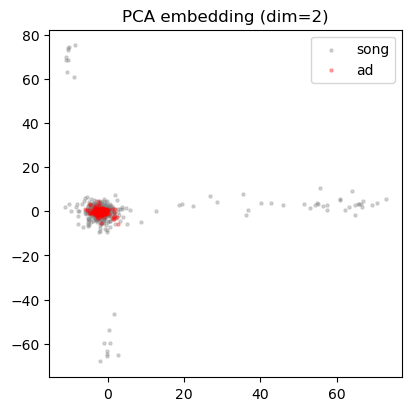

In [25]:
plt.close("all")

fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")

ax.scatter(embed_pca[~y, 0], embed_pca[~y, 1],
              c="gray", label="song", alpha=0.3, s=5)
ax.scatter(embed_pca[y, 0], embed_pca[y, 1],
              c="red", label="ad", alpha=0.3, s=5)
ax.set_title(f"PCA embedding (dim={embedding_dim})")

plt.legend(loc="best")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-PCA.png", dpi=300)

plt.show()

### Spectral Embedding

In [26]:
gamma_range = np.logspace(-2, 1, 4) 
param_grid_rbf = {
    'n_components': [2],
    'affinity': ['rbf'],
    'gamma': gamma_range,
}

neighbors_range = np.logspace(2, 8, 4, base=2, dtype=int)  
param_grid_nn = {
    'n_components': [2],
    'affinity': ['nearest_neighbors'],
    'n_neighbors': neighbors_range,
}

grid_rbf = list(ParameterGrid(param_grid_rbf))
grid_nn = list(ParameterGrid(param_grid_nn))

In [27]:
spectral_embeddings = []
for params in grid_rbf:
    spectral = SpectralEmbedding(**params)
    embed_spectral = spectral.fit_transform(X)
    spectral_embeddings.append(embed_spectral)

for params in grid_nn:
    spectral = SpectralEmbedding(**params)
    embed_spectral = spectral.fit_transform(X)
    spectral_embeddings.append(embed_spectral)

/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [28]:
params_combined = grid_rbf + grid_nn

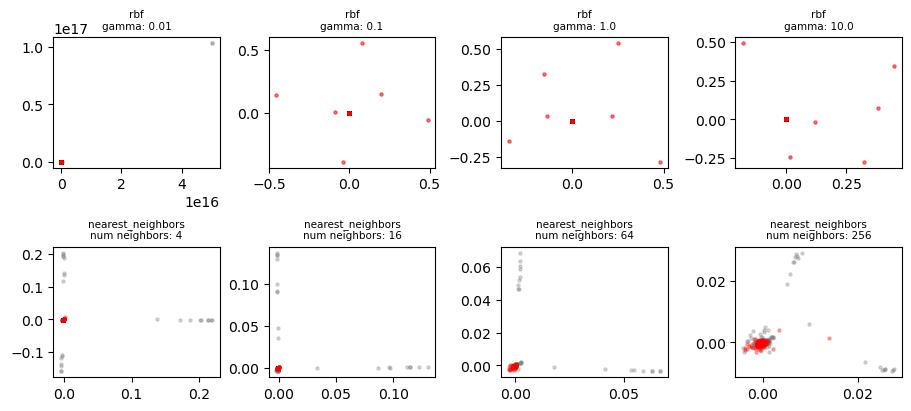

In [29]:
plt.close("all")

fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(spectral_embeddings[i][~y, 0], spectral_embeddings[i][~y, 1], 
               c="gray", label="song", alpha=0.3, s=5)
    ax.scatter(spectral_embeddings[i][y, 0], spectral_embeddings[i][y, 1], 
               c="red", label="ad", alpha=0.3, s=5)

    if params_combined[i]["affinity"] == "rbf":
        ax.set_title(f'{params_combined[i]["affinity"]}\ngamma: {params_combined[i]["gamma"]}', fontsize=7.5)
    else:
        ax.set_title(f'{params_combined[i]["affinity"]}\nnum neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)


# plt.legend(loc="upper right")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-spectral.png", dpi=300)

plt.show()

### t-SNE

In [30]:
# perplexity_range = np.logspace(2, 9, 8, base=2, dtype=int)
perplexity_range = [2, 32, 64, 128, 256, 512, 768, 896]
perplexity_range

[2, 32, 64, 128, 256, 512, 768, 896]

In [31]:
param_grid_tsne = {
    'n_components': [2],
    'perplexity': perplexity_range,
}

grid_tsne = list(ParameterGrid(param_grid_tsne))

In [32]:
tsne_embeddings = []
for params in grid_tsne:
    model = TSNE(**params, n_iter=10000)
    embedding = model.fit_transform(X)
    tsne_embeddings.append(embedding)

In [33]:
params_combined = grid_tsne

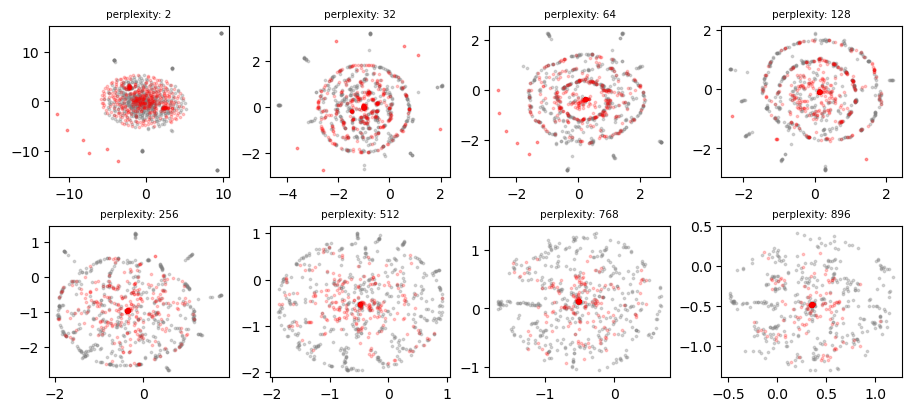

In [34]:
plt.close("all")

fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(tsne_embeddings[i][~y, 0], tsne_embeddings[i][~y, 1], 
               c="gray", label="song", alpha=0.3, s=3)
    ax.scatter(tsne_embeddings[i][y, 0], tsne_embeddings[i][y, 1], 
               c="red", label="ad", alpha=0.2, s=3)

    ax.set_title(f'perplexity: {params_combined[i]["perplexity"]}', fontsize=7.5)


# plt.legend(loc="upper right")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-tsne.png", dpi=300)

plt.show()

### UMAP

* euclidean
* manhattan
* chebyshev
* minkowski
* canberra
* braycurtis
* mahalanobis
* wminkowski
* seuclidean
* cosine
* correlation
* haversine
* hamming
* jaccard
* dice
* russelrao
* kulsinski
* ll_dirichlet
* hellinger
* rogerstanimoto
* sokalmichener
* sokalsneath
* yule

In [56]:
nn_range = [2, 5, 15, 50, 100, 150, 200, 500]
metric_range = ["chebychev"]

In [57]:
param_grid_umap = {
    'n_components': [2],
    'min_dist': [0.0],
    'n_neighbors': nn_range,
    'metric': metric_range 
}
grid_umap = list(ParameterGrid(param_grid_umap))

In [168]:
params_combined = grid_umap

In [169]:
umap_embeddings = []
for params in grid_umap:
    model = umap.UMAP(**params)
    embedding = model.fit_transform(X)
    umap_embeddings.append(embedding)

/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


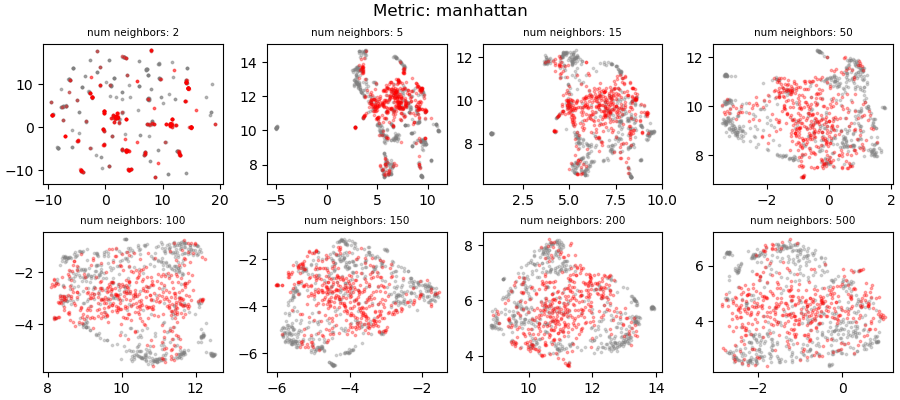

In [170]:
plt.close("all")

fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(umap_embeddings[i][~y, 0], umap_embeddings[i][~y, 1], 
               c="gray", label="song", alpha=0.3, s=3)
    ax.scatter(umap_embeddings[i][y, 0], umap_embeddings[i][y, 1], 
               c="red", label="ad", alpha=0.3, s=3)

    ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)

# plt.legend(loc="upper right")

fig.suptitle(f'Metric: {params_combined[i]["metric"]}')

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-umap-{params_combined[i]['metric']}.png", dpi=300)

plt.show()

### UMAP – all

In [38]:
nn_range = [2, 5, 15, 50, 100, 150, 200, 500]

In [39]:
distance_metrics = [
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    "canberra",
    "braycurtis",
    "cosine",
    "correlation",
]

In [ ]:
for metric_range in tqdm(distance_metrics):
    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range,
        'metric': [metric_range] 
    }
    grid_umap = list(ParameterGrid(param_grid_umap))

    params_combined = grid_umap

    # project datapoints to embedding
    umap_embeddings = []
    for params in grid_umap:
        model = umap.UMAP(**params)
        embedding = model.fit_transform(X)
        umap_embeddings.append(embedding)


    # plot
    plt.close("all")
    
    fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")
    
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.scatter(umap_embeddings[i][~y, 0], umap_embeddings[i][~y, 1], 
                   c="gray", label="song", alpha=0.3, s=3)
        ax.scatter(umap_embeddings[i][y, 0], umap_embeddings[i][y, 1], 
                   c="red", label="ad", alpha=0.3, s=3)
    
        ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)
    
    # plt.legend(loc="upper right")
    
    fig.suptitle(f'Metric: {params_combined[i]["metric"]}')
    
    plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-umap-{params_combined[i]['metric']}.png", dpi=300)
    
    plt.close("all")

Supervised clustering with UMAP

In [41]:
distance_metrics = [
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    "canberra",
    "braycurtis",
    "cosine",
    "correlation",
]

In [42]:
target = [1 if x else 0 for x in y]

In [ ]:
for metric_range in tqdm(distance_metrics):
    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range,
        'metric': [metric_range] 
    }
    grid_umap = list(ParameterGrid(param_grid_umap))

    params_combined = grid_umap

    # project datapoints to embedding
    umap_embeddings = []
    for params in grid_umap:
        model = umap.UMAP(**params)
        embedding = model.fit_transform(X, y=target)
        umap_embeddings.append(embedding)


    # plot
    plt.close("all")
    
    fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")
    
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.scatter(umap_embeddings[i][~y, 0], umap_embeddings[i][~y, 1], 
                   c="gray", label="song", alpha=0.3, s=3)
        ax.scatter(umap_embeddings[i][y, 0], umap_embeddings[i][y, 1], 
                   c="red", label="ad", alpha=0.3, s=3)
    
        ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)
    
    # plt.legend(loc="upper right")
    
    fig.suptitle(f'Metric: {params_combined[i]["metric"]}')
    
    plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-supervised-umap-{params_combined[i]['metric']}.png", dpi=300)
    
    plt.close("all")

### Supervised UMAP

Shows most promise from a practical point of view. Let's see how it performs on un-seen data.

In [45]:
kf = KFold(n_splits=5, shuffle=True)

In [46]:
target = np.array([1 if x else 0 for x in y])

In [47]:
nn_range = {
    "euclidean" : [8, 10, 15, 25, 30, 50, 75], # Changed
    "manhattan" : [8, 10, 15, 25, 30, 50, 75], # Changed
    "chebyshev" : [5, 10, 15, 25, 30, 50, 75], # Changed
    "minkowski" : [8, 10, 15, 25, 30, 50, 75], # Not changed
    "canberra" : [15, 20, 25, 30, 50, 75, 100], # Not changed
    "braycurtis" : [5, 10, 15, 25, 30, 50, 75], # Not changed
    "cosine" : [5, 10, 15, 25, 30, 50, 75], # Not changed
    "correlation" : [5, 10, 15, 25, 30, 50, 75] # Not changed
}

In [48]:
distance_metrics = [
    "braycurtis",
    "cosine",
    "correlation",
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    "canberra"
]

In [ ]:
statistics = []

for epoch, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], target[train_idx], target[test_idx]

    fold_statistics = []
    for metric_range in tqdm(distance_metrics):
        print(metric_range)
        # Define parameters
        param_grid_umap = {
            'n_components': [2],
            'min_dist': [0.0],
            'n_neighbors': nn_range[metric_range],
            'metric': [metric_range] 
        }
        grid_umap = list(ParameterGrid(param_grid_umap))
        
        params_combined = grid_umap

        # Perform Grid Search
        umap_train = []
        umap_test = []
        print("performing grid search...")
        for params in tqdm(grid_umap):
        
            model = umap.UMAP(**params, target_weight=0.2).fit(X_train, y=y_train)
            train_embedding = model.embedding_
            test_embedding = model.transform(X_test)
            
            umap_train.append(train_embedding)
            umap_test.append(test_embedding)


        kmeans_labels = []
        for i in range(len(grid_umap)):
            # Perform K Means clustering as a quantification tool
            combined_data = np.concatenate([umap_train[i], umap_test[i]], axis=0)
            
            kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(combined_data)
            
            
            y_pred = kmeans.labels_[X_train.shape[0]:]
            y_true = y_test.astype(np.int32)
            
            corr_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
            
            # If the correlation coefficient is negative, flip the predicted labels
            if corr_coefficient < 0:
                y_pred = 1 - y_pred
                kmeans_labels.append(1 - kmeans.labels_)
            else:
                kmeans_labels.append(kmeans.labels_)
            
            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred)
            auroc = roc_auc_score(y_true, y_pred)
            
            fold_statistics.append([acc, f1, prec, auroc])



        # plot
        y_train = y_train.astype(bool)
        y_test = y_test.astype(bool)
            
        plt.close("all")
        
        fig, ax = plt.subplots(len(grid_umap), 2, figsize=(4, 2 * len(grid_umap)))

        for i in range(ax.shape[0]):
        
            ax[i, 0].scatter(umap_train[i][~y_train, 0], umap_train[i][~y_train, 1], 
                       c="gray", label="song-train", alpha=0.3, s=3)
            ax[i, 0].scatter(umap_test[i][~y_test, 0], umap_test[i][~y_test, 1], 
                       c="navy", label="song-test", alpha=0.3, s=3)
            
            ax[i, 0].scatter(umap_train[i][y_train, 0], umap_train[i][y_train, 1], 
                       c="red", label="ad-train", alpha=0.3, s=3)
            ax[i, 0].scatter(umap_test[i][y_test, 0], umap_test[i][y_test, 1], 
                       c="orange", label="ad-test", alpha=0.3, s=3)
            
            ax[i, 0].set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)

            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
            
            
            
            # K Means labelling
            combined_data = np.concatenate([umap_train[i], umap_test[i]], axis=0)
            combined_pred = kmeans_labels[i].astype(bool)
            ax[i, 1].scatter(combined_data[~combined_pred, 0], combined_data[~combined_pred, 1], 
                       c="blue", label="song", alpha=0.3, s=3)
            ax[i, 1].scatter(combined_data[combined_pred, 0], combined_data[combined_pred, 1], 
                       c="red", label="ad", alpha=0.3, s=3)
            
            ax[i, 1].set_title('K Means', fontsize=7.5)

            ax[i, 1].set_xticks([])
            ax[i, 1].set_yticks([])
            
            
        fig.suptitle(f'Metric: {metric_range}')
        
        plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv{epoch}-umap-{metric_range}.png", dpi=300)
        
        plt.close("all")


    statistics.append(fold_statistics)

In [50]:
statistics = np.array(statistics)

In [51]:
statistics.shape

(1, 56, 4)

In [52]:
avg_statistics = np.mean(statistics, axis=0)

In [53]:
all_parameters = []
for metric_range in distance_metrics:

    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range[metric_range],
        'metric': [metric_range] 
    }
    grid_umap = list(ParameterGrid(param_grid_umap))
    
    params_combined = grid_umap

    for params in grid_umap:
        all_parameters.append(params) # in correct order

In [54]:
%matplotlib widget

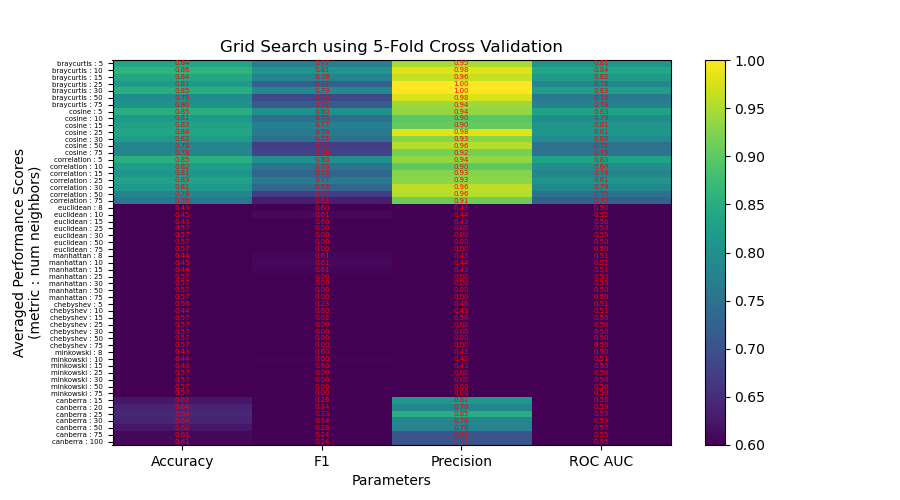

In [57]:
plt.close()

fig = plt.figure(figsize=(9, 5))

im = plt.imshow(avg_statistics, aspect="auto", vmin=0.6)

plt.xlabel("Parameters")
plt.ylabel("Averaged Performance Scores\n(metric : num neighbors)")

plt.colorbar(im)

# Relabeling x-axis ticks
plt.xticks(ticks=np.arange(4), labels=["Accuracy", "F1", "Precision", "ROC AUC"])

# Relabeling y-axis ticks
plt.yticks(ticks=np.arange(len(all_parameters)), labels=[f'{x["metric"]} : {x["n_neighbors"]}' for x in all_parameters], fontsize=5)


# Add text of the value itself in each heatmap pixel
for i in range(len(all_parameters)):
    for j in range(4):
        plt.text(j, i, f'{avg_statistics[i, j]:.2f}', ha='center', va='center', color='red', fontsize=5)

plt.title("Grid Search using 5-Fold Cross Validation")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv0-umap-all-results.png", dpi=400)

plt.show()

Its overfitting slightly a bit too much. Let's drive down the `target_weight` to 0

In [58]:
target_weight = 0

In [ ]:
statistics = []

for epoch, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], target[train_idx], target[test_idx]

    fold_statistics = []
    for metric_range in tqdm(distance_metrics):
        print(metric_range)
        # Define parameters
        param_grid_umap = {
            'n_components': [2],
            'min_dist': [0.0],
            'n_neighbors': nn_range[metric_range],
            'metric': [metric_range] 
        }
        grid_umap = list(ParameterGrid(param_grid_umap))
        
        params_combined = grid_umap

        # Perform Grid Search
        umap_train = []
        umap_test = []
        print("performing grid search...")
        for params in tqdm(grid_umap):
        
            model = umap.UMAP(**params, target_weight=target_weight).fit(X_train, y=y_train)
            train_embedding = model.embedding_
            test_embedding = model.transform(X_test)
            
            umap_train.append(train_embedding)
            umap_test.append(test_embedding)


        kmeans_labels = []
        for i in range(len(grid_umap)):
            # Perform K Means clustering as a quantification tool
            combined_data = np.concatenate([umap_train[i], umap_test[i]], axis=0)
            
            kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(combined_data)
            
            
            y_pred = kmeans.labels_[X_train.shape[0]:]
            y_true = y_test.astype(np.int32)
            
            corr_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
            
            # If the correlation coefficient is negative, flip the predicted labels
            if corr_coefficient < 0:
                y_pred = 1 - y_pred
                kmeans_labels.append(1 - kmeans.labels_)
            else:
                kmeans_labels.append(kmeans.labels_)
            
            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred)
            auroc = roc_auc_score(y_true, y_pred)
            
            fold_statistics.append([acc, f1, prec, auroc])



        # plot
        y_train = y_train.astype(bool)
        y_test = y_test.astype(bool)
            
        plt.close("all")
        
        fig, ax = plt.subplots(len(grid_umap), 2, figsize=(4, 2 * len(grid_umap)))

        for i in range(ax.shape[0]):
        
            ax[i, 0].scatter(umap_train[i][~y_train, 0], umap_train[i][~y_train, 1], 
                       c="gray", label="song-train", alpha=0.3, s=3)
            ax[i, 0].scatter(umap_test[i][~y_test, 0], umap_test[i][~y_test, 1], 
                       c="navy", label="song-test", alpha=0.3, s=3)
            
            ax[i, 0].scatter(umap_train[i][y_train, 0], umap_train[i][y_train, 1], 
                       c="red", label="ad-train", alpha=0.3, s=3)
            ax[i, 0].scatter(umap_test[i][y_test, 0], umap_test[i][y_test, 1], 
                       c="orange", label="ad-test", alpha=0.3, s=3)
            
            ax[i, 0].set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)

            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
            
            
            
            # K Means labelling
            combined_data = np.concatenate([umap_train[i], umap_test[i]], axis=0)
            combined_pred = kmeans_labels[i].astype(bool)
            ax[i, 1].scatter(combined_data[~combined_pred, 0], combined_data[~combined_pred, 1], 
                       c="blue", label="song", alpha=0.3, s=3)
            ax[i, 1].scatter(combined_data[combined_pred, 0], combined_data[combined_pred, 1], 
                       c="red", label="ad", alpha=0.3, s=3)
            
            ax[i, 1].set_title('K Means', fontsize=7.5)

            ax[i, 1].set_xticks([])
            ax[i, 1].set_yticks([])
            
            
        fig.suptitle(f'Metric: {metric_range}')
        
        plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv{epoch}-umap-tw{target_weight}-{metric_range}.png", dpi=300)
        
        plt.close("all")

    statistics.append(fold_statistics)

In [60]:
statistics = np.array(statistics)

In [61]:
statistics.shape

(5, 56, 4)

In [62]:
avg_statistics = np.mean(statistics, axis=0)

In [63]:
all_parameters = []
for metric_range in distance_metrics:

    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range[metric_range],
        'metric': [metric_range] 
    }
    grid_umap = list(ParameterGrid(param_grid_umap))
    
    params_combined = grid_umap

    for params in grid_umap:
        all_parameters.append(params) # in correct order

In [64]:
%matplotlib widget

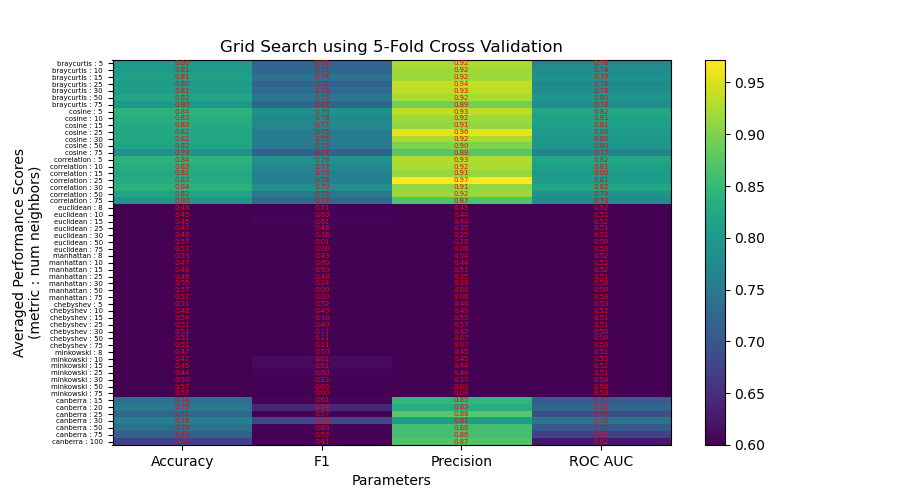

In [66]:
plt.close()

fig = plt.figure(figsize=(9, 5))

im = plt.imshow(avg_statistics, aspect="auto", vmin=0.6)

plt.xlabel("Parameters")
plt.ylabel("Averaged Performance Scores\n(metric : num neighbors)")

plt.colorbar(im)

# Relabeling x-axis ticks
plt.xticks(ticks=np.arange(4), labels=["Accuracy", "F1", "Precision", "ROC AUC"])

# Relabeling y-axis ticks
plt.yticks(ticks=np.arange(len(all_parameters)), labels=[f'{x["metric"]} : {x["n_neighbors"]}' for x in all_parameters], fontsize=5)


# Add text of the value itself in each heatmap pixel
for i in range(len(all_parameters)):
    for j in range(4):
        plt.text(j, i, f'{avg_statistics[i, j]:.2f}', ha='center', va='center', color='red', fontsize=5)

plt.title("Grid Search using 5-Fold Cross Validation")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv-umap-tw{target_weight}-all-results.png", dpi=400)

plt.show()

In [67]:
f1_idx = 1
k = 0 # max
all_parameters[np.argsort(avg_statistics[:, f1_idx])[::-1][k]]
# Optimal parameter combination

{'metric': 'correlation', 'min_dist': 0.0, 'n_components': 2, 'n_neighbors': 5}

In [68]:
for k in range(10):
    top_k_param = all_parameters[np.argsort(avg_statistics[:, f1_idx])[::-1][k]]
    print(f'{top_k_param["metric"]} : {top_k_param["n_neighbors"]} f1={np.sort(avg_statistics[:, f1_idx])[::-1][k] :.3f}')

correlation : 5 f1=0.787
correlation : 30 f1=0.787
cosine : 5 f1=0.786
cosine : 10 f1=0.776
cosine : 15 f1=0.773
correlation : 10 f1=0.773
correlation : 15 f1=0.764
correlation : 25 f1=0.761
cosine : 30 f1=0.755
cosine : 25 f1=0.753


If its still overfitting, then it may be better to simply `fit` to get a model on training data and then `transform` the testing data blindly (without supervised labels). We already have results for this so we know which parameters will work and the ballpark of num neighbors – I just want to visualize the train-test performance.

Still a fair amount of overfitting but it might be OKAY (correlation and cosine). I do want to run this final experiment though.

### Semisupervised UMAP 

With train test folds and using "learned" embedding 

In [73]:
kf = KFold(n_splits=5, shuffle=True)

In [74]:
target = np.array([1 if x else 0 for x in y])

In [75]:
nn_range = {
    "euclidean" : [5, 10, 15, 25, 30, 50, 100], # Changed
    "manhattan" : [5, 10, 15, 25, 30, 50, 100], # Changed
    "chebyshev" : [5, 10, 15, 25, 30, 50, 100], # Changed
    "minkowski" : [5, 10, 15, 25, 30, 50, 100], # Changed
    "canberra" : [5, 10, 15, 25, 30, 50, 100], # Changed
    "braycurtis" : [5, 10, 15, 25, 30, 50, 100], # Changed
    "cosine" : [5, 10, 15, 25, 30, 50, 100], # Changed
    "correlation" : [5, 10, 15, 25, 30, 50, 100] # Changed
}

In [76]:
distance_metrics = [
    "braycurtis",
    "cosine",
    "correlation",
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    "canberra"
]

In [ ]:
for epoch, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], target[train_idx], target[test_idx]

    fold_statistics = []
    for metric_range in tqdm(distance_metrics):
        print(metric_range)
        # Define parameters
        param_grid_umap = {
            'n_components': [2],
            'min_dist': [0.0],
            'n_neighbors': nn_range[metric_range],
            'metric': [metric_range] 
        }
        grid_umap = list(ParameterGrid(param_grid_umap))
        
        params_combined = grid_umap

        # Perform Grid Search
        umap_train = []
        umap_test = []
        print("performing grid search...")
        for params in tqdm(grid_umap):
        
            model = umap.UMAP(**params).fit(X_train)
            train_embedding = model.embedding_
            test_embedding = model.transform(X_test)
            
            umap_train.append(train_embedding)
            umap_test.append(test_embedding)


        # plot
        y_train = y_train.astype(bool)
        y_test = y_test.astype(bool)
            
        plt.close("all")
        
        fig, ax = plt.subplots(len(grid_umap), 2, figsize=(4, 2 * len(grid_umap)))

        for i in range(ax.shape[0]):
        
            ax[i, 0].scatter(umap_train[i][~y_train, 0], umap_train[i][~y_train, 1], 
                       c="gray", label="song-train", alpha=0.3, s=3)
            ax[i, 0].scatter(umap_test[i][~y_test, 0], umap_test[i][~y_test, 1], 
                       c="navy", label="song-test", alpha=0.3, s=3)
            
            ax[i, 0].scatter(umap_train[i][y_train, 0], umap_train[i][y_train, 1], 
                       c="red", label="ad-train", alpha=0.3, s=3)
            ax[i, 0].scatter(umap_test[i][y_test, 0], umap_test[i][y_test, 1], 
                       c="orange", label="ad-test", alpha=0.3, s=3)
            
            ax[i, 0].set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)

            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
            
            
        fig.suptitle(f'Metric: {metric_range}')
        
        plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv{epoch}-semisupervised-umap-{metric_range}.png", dpi=300)
        
        plt.close("all")

## Final Eval 

For unnormalized raw data: UMAP Canberra vs Braycurtis

For normalized raw data: UMAP Correlation vs Cosine

In [100]:
nn_range = {
    "correlation" : [5, 10, 15, 20, 30, 35, 40, 150], # changed
    "cosine" : [5, 10, 15, 20, 30, 35, 40, 150], # changed
}

In [101]:
tw_range = [0.5, 0.2, 0.0]

In [102]:
distance_metrics = [
    "correlation",
    "cosine"
]

In [ ]:
statistics = []

for epoch, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], target[train_idx], target[test_idx]

    fold_statistics = []
    for metric_range in tqdm(distance_metrics):
        print(metric_range)
        # Define parameters
        param_grid_umap = {
            'n_components': [2],
            'min_dist': [0.0],
            'n_neighbors': nn_range[metric_range],
            'metric': [metric_range],
            'target_weight': tw_range
        }
        grid_umap = list(ParameterGrid(param_grid_umap))
        
        params_combined = grid_umap

        # Perform Grid Search
        umap_train = []
        umap_test = []
        print("performing grid search...")
        for params in tqdm(grid_umap):
        
            model = umap.UMAP(**params).fit(X_train, y=y_train)
            train_embedding = model.embedding_
            test_embedding = model.transform(X_test)
            
            umap_train.append(train_embedding)
            umap_test.append(test_embedding)


        kmeans_labels = []
        for i in range(len(grid_umap)):
            # Perform K Means clustering as a quantification tool
            combined_data = np.concatenate([umap_train[i], umap_test[i]], axis=0)
            
            kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(combined_data)
            
            y_pred = kmeans.labels_[X_train.shape[0]:]
            y_true = y_test.astype(np.int32)
            
            corr_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
            
            # If the correlation coefficient is negative, flip the predicted labels
            if corr_coefficient < 0:
                y_pred = 1 - y_pred
                kmeans_labels.append(1 - kmeans.labels_)
            else:
                kmeans_labels.append(kmeans.labels_)
            
            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred)
            auroc = roc_auc_score(y_true, y_pred)
            
            fold_statistics.append([acc, f1, prec, auroc])
            
        
        y_train = y_train.astype(bool)
        y_test = y_test.astype(bool)

        plt.close("all")
        
        num_rows = np.ceil(len(grid_umap) / 3).astype(int)  # Use ceiling division to ensure all plots fit.
        
        fig, ax = plt.subplots(num_rows, 6, figsize=(12, 2 * num_rows + 1))  # Six columns for the plots
        
        for i in range(num_rows):
            # Index for accessing data
            idx1 = 3 * i
            idx2 = 3 * i + 1
            idx3 = 3 * i + 2
        
            # First column: UMAP plot for umap_test[idx1]
            if idx1 < len(grid_umap):
            
                ax[i, 0].scatter(umap_train[idx1][~y_train, 0], umap_train[idx1][~y_train, 1], 
                           c="gray", label="song-train", alpha=0.3, s=3)
                ax[i, 0].scatter(umap_test[idx1][~y_test, 0], umap_test[idx1][~y_test, 1], 
                           c="navy", label="song-test", alpha=0.3, s=3)
                
                ax[i, 0].scatter(umap_train[idx1][y_train, 0], umap_train[idx1][y_train, 1], 
                           c="red", label="ad-train", alpha=0.3, s=3)
                ax[i, 0].scatter(umap_test[idx1][y_test, 0], umap_test[idx1][y_test, 1], 
                           c="orange", label="ad-test", alpha=0.3, s=3)
                
                ax[i, 0].set_title(f'num neighbors: {params_combined[idx1]["n_neighbors"]}\ntarget weight: {params_combined[idx1]["target_weight"]}', fontsize=7.5)
        
                ax[i, 0].set_xticks([])
                ax[i, 0].set_yticks([])
        
            # Second column: UMAP plot for umap_test[idx2] if exists
            if idx2 < len(grid_umap):
                ax[i, 1].scatter(umap_train[idx2][~y_train, 0], umap_train[idx2][~y_train, 1], 
                           c="gray", label="song-train", alpha=0.3, s=3)
                ax[i, 1].scatter(umap_test[idx2][~y_test, 0], umap_test[idx2][~y_test, 1], 
                           c="navy", label="song-test", alpha=0.3, s=3)
                
                ax[i, 1].scatter(umap_train[idx2][y_train, 0], umap_train[idx2][y_train, 1], 
                           c="red", label="ad-train", alpha=0.3, s=3)
                ax[i, 1].scatter(umap_test[idx2][y_test, 0], umap_test[idx2][y_test, 1], 
                           c="orange", label="ad-test", alpha=0.3, s=3)
                
                ax[i, 1].set_title(f'num neighbors: {params_combined[idx2]["n_neighbors"]}\ntarget weight: {params_combined[idx2]["target_weight"]}', fontsize=7.5)
        
                ax[i, 1].set_xticks([])
                ax[i, 1].set_yticks([])

            # Third column: UMAP plot for umap_test[idx3] if it exists
            if idx3 < len(grid_umap):
                ax[i, 2].scatter(umap_train[idx3][~y_train, 0], umap_train[idx3][~y_train, 1],
                                  c="gray", label="song-train", alpha=0.3, s=3)
                ax[i, 2].scatter(umap_test[idx3][~y_test, 0], umap_test[idx3][~y_test, 1],
                                  c="navy", label="song-test", alpha=0.3, s=3)
                
                ax[i, 2].scatter(umap_train[idx3][y_train, 0], umap_train[idx3][y_train, 1],
                                  c="red", label="ad-train", alpha=0.3, s=3)
                ax[i, 2].scatter(umap_test[idx3][y_test, 0], umap_test[idx3][y_test, 1],
                                  c="orange", label="ad-test", alpha=0.3, s=3)
                
                ax[i, 2].set_title(f'num neighbors: {params_combined[idx2]["n_neighbors"]}\ntarget weight: {params_combined[idx2]["target_weight"]}', fontsize=7.5)
                
                ax[i, 2].set_xticks([])
                ax[i, 2].set_yticks([])
                
            
            # K Means labelling
            # Fourth column: K-Means plot for umap_test[idx1]
            if idx1 < len(grid_umap):
                combined_data = np.concatenate([umap_train[idx1], umap_test[idx1]], axis=0)
                combined_pred = kmeans_labels[idx1].astype(bool)
                ax[i, 3].scatter(combined_data[~combined_pred, 0], combined_data[~combined_pred, 1], 
                           c="blue", label="song", alpha=0.3, s=3)
                ax[i, 3].scatter(combined_data[combined_pred, 0], combined_data[combined_pred, 1], 
                           c="red", label="ad", alpha=0.3, s=3)
                ax[i, 3].set_title('K-Means', fontsize=7.5)
                ax[i, 3].set_xticks([])
                ax[i, 3].set_yticks([])
        
            # Fifth column: K-Means plot for umap_test[idx2] if it exists
            if idx2 < len(grid_umap):
                combined_data = np.concatenate([umap_train[idx2], umap_test[idx2]], axis=0)
                combined_pred = kmeans_labels[idx2].astype(bool)
                ax[i, 4].scatter(combined_data[~combined_pred, 0], combined_data[~combined_pred, 1], 
                           c="blue", label="song", alpha=0.3, s=3)
                ax[i, 4].scatter(combined_data[combined_pred, 0], combined_data[combined_pred, 1], 
                           c="red", label="ad", alpha=0.3, s=3)
                ax[i, 4].set_title('K-Means', fontsize=7.5)
                ax[i, 4].set_xticks([])
                ax[i, 4].set_yticks([])


            # Sixth column: K-Means plot for umap_test[idx3] if it exists
            if idx3 < len(grid_umap):
                combined_data = np.concatenate([umap_train[idx3], umap_test[idx3]], axis=0)
                combined_pred = kmeans_labels[idx3].astype(bool)
                ax[i, 5].scatter(combined_data[~combined_pred, 0], combined_data[~combined_pred, 1],
                                  c="blue", label="song", alpha=0.3, s=3)
                ax[i, 5].scatter(combined_data[combined_pred, 0], combined_data[combined_pred, 1],
                                  c="red", label="ad", alpha=0.3, s=3)
                ax[i, 5].set_title('K-Means', fontsize=7.5)
                ax[i, 5].set_xticks([])
                ax[i, 5].set_yticks([])
                
            
        fig.suptitle(f'Metric: {metric_range}')
        
        plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv-opt2-{epoch}-supervised-umap-{metric_range}.png", dpi=300)
        
        plt.close("all")
        
    statistics.append(fold_statistics)

In [104]:
statistics = np.array(statistics)

In [105]:
statistics.shape

(5, 48, 4)

In [106]:
avg_statistics = np.mean(statistics, axis=0)

In [107]:
all_parameters = []
for metric_range in distance_metrics:

    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range[metric_range],
        'metric': [metric_range],
        'target_weight': tw_range
    }
    grid_umap = list(ParameterGrid(param_grid_umap))
    
    params_combined = grid_umap

    for params in grid_umap:
        all_parameters.append(params) # in correct order

In [108]:
%matplotlib widget

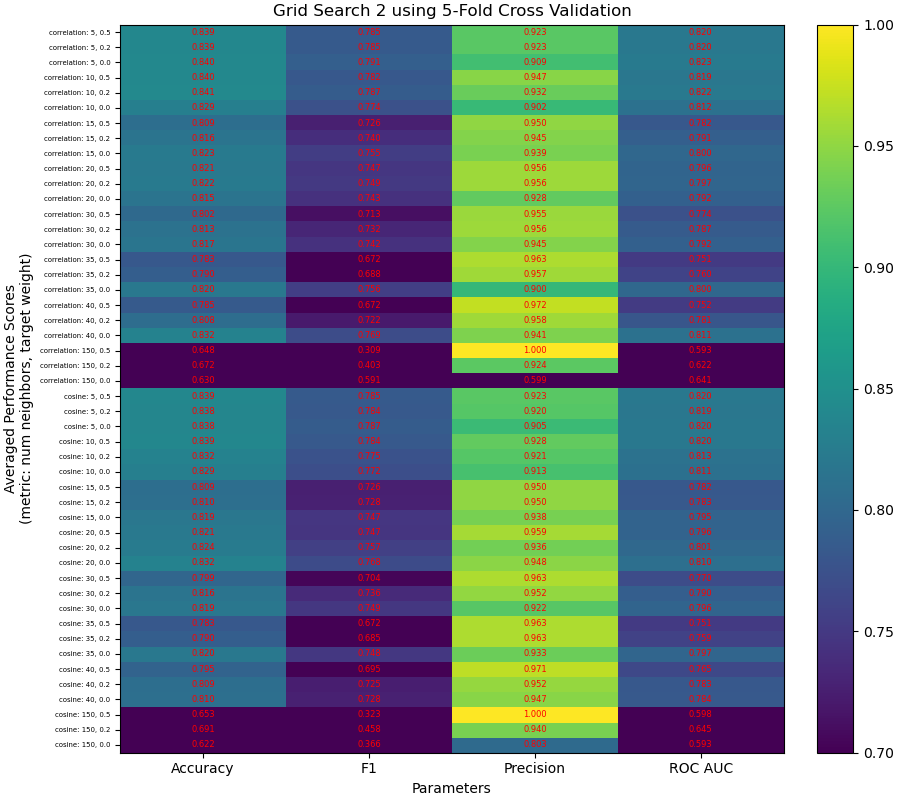

In [115]:
plt.close()

fig = plt.figure(figsize=(9, 8), layout="constrained")

im = plt.imshow(avg_statistics, aspect="auto", vmin=0.7)

plt.xlabel("Parameters")
plt.ylabel("Averaged Performance Scores\n(metric: num neighbors, target weight)")

plt.colorbar(im)

# Relabeling x-axis ticks
plt.xticks(ticks=np.arange(4), labels=["Accuracy", "F1", "Precision", "ROC AUC"])

# Relabeling y-axis ticks
plt.yticks(ticks=np.arange(len(all_parameters)), labels=[f'{x["metric"]}: {x["n_neighbors"]}, {x["target_weight"]}' for x in all_parameters], fontsize=5)


# Add text of the value itself in each heatmap pixel
for i in range(len(all_parameters)):
    for j in range(4):
        plt.text(j, i, f'{avg_statistics[i, j]:.3f}', ha='center', va='center', color='red', fontsize=6)

plt.title("Grid Search 2 using 5-Fold Cross Validation")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-cv-opt2-supervised-umap-all-results.png", dpi=400)

plt.show()

In [116]:
f1_idx = 1
k = 0 # max
all_parameters[np.argsort(avg_statistics[:, f1_idx])[::-1][k]]
# Optimal parameter combination

{'metric': 'correlation',
 'min_dist': 0.0,
 'n_components': 2,
 'n_neighbors': 5,
 'target_weight': 0.0}

In [124]:
sorted_statistics = np.argsort(avg_statistics[:, f1_idx])[::-1]

In [128]:
for k in range(10):
    top_k_param = all_parameters[np.argsort(avg_statistics[:, f1_idx])[::-1][k]]
    print(f'{top_k_param["metric"]}: {top_k_param["n_neighbors"]}, {top_k_param["target_weight"]}', end=" | ")
    print(f'f1={avg_statistics[sorted_statistics, f1_idx][k] :.3f} acc={avg_statistics[sorted_statistics, 0][k] :.3f}', end=" ")
    print(f'prec={avg_statistics[sorted_statistics, 2][k] :.3f} auroc={avg_statistics[sorted_statistics, 3][k] :.3f}')

correlation: 5, 0.0 | f1=0.791 acc=0.840 prec=0.909 auroc=0.823
correlation: 10, 0.2 | f1=0.787 acc=0.841 prec=0.932 auroc=0.822
cosine: 5, 0.0 | f1=0.787 acc=0.838 prec=0.905 auroc=0.820
cosine: 5, 0.5 | f1=0.785 acc=0.839 prec=0.923 auroc=0.820
correlation: 5, 0.5 | f1=0.785 acc=0.839 prec=0.923 auroc=0.820
correlation: 5, 0.2 | f1=0.785 acc=0.839 prec=0.923 auroc=0.820
cosine: 10, 0.5 | f1=0.784 acc=0.839 prec=0.928 auroc=0.820
cosine: 5, 0.2 | f1=0.784 acc=0.838 prec=0.920 auroc=0.819
correlation: 10, 0.5 | f1=0.782 acc=0.840 prec=0.947 auroc=0.819
cosine: 10, 0.2 | f1=0.775 acc=0.832 prec=0.921 auroc=0.813


In [169]:
f1_cutoff

array([ True,  True,  True,  True,  True,  True, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [176]:
# Assuming all_parameters and avg_statistics are defined as described
f1_idx = 1  # You need to ensure this index corresponds to the F1 score in your avg_statistics array
prec_idx = 2  # Already given

# Filter parameters by F1 score cutoff
f1_cutoff = avg_statistics[:, f1_idx] > 0.7

# Get the subset of parameters that meet the F1 cutoff
filtered_indices = np.where(f1_cutoff)[0]
subset_param = [all_parameters[i] for i in filtered_indices]

# Get indices of the sorted subset by precision in descending order
sorted_indices = np.argsort(avg_statistics[f1_cutoff, prec_idx])[::-1]

# Print the top k parameters, adjusting k as needed
k = 10  # You can adjust this value based on how many top results you want
for i in range(min(k, len(sorted_indices))):  # This avoids an out-of-range error if fewer than k results meet the criteria
    idx = sorted_indices[i]
    print(f'{subset_param[idx]["metric"]}: {subset_param[idx]["n_neighbors"]}, {subset_param[idx]["target_weight"]}', end=" | ")
    print(f'f1={avg_statistics[f1_cutoff][idx, f1_idx]:.3f}', end=" ")
    print(f'acc={avg_statistics[f1_cutoff][idx, 0]:.3f}', end=" ")
    print(f'prec={avg_statistics[f1_cutoff][idx, prec_idx]:.3f}', end=" ")
    print(f'auroc={avg_statistics[f1_cutoff][idx, 3]:.3f}')


cosine: 30, 0.5 | f1=0.704 acc=0.799 prec=0.963 auroc=0.770
cosine: 20, 0.5 | f1=0.747 acc=0.821 prec=0.959 auroc=0.796
correlation: 40, 0.2 | f1=0.722 acc=0.808 prec=0.958 auroc=0.781
correlation: 30, 0.2 | f1=0.732 acc=0.813 prec=0.956 auroc=0.787
correlation: 20, 0.2 | f1=0.749 acc=0.822 prec=0.956 auroc=0.797
correlation: 20, 0.5 | f1=0.747 acc=0.821 prec=0.956 auroc=0.796
correlation: 30, 0.5 | f1=0.713 acc=0.802 prec=0.955 auroc=0.774
cosine: 40, 0.2 | f1=0.725 acc=0.809 prec=0.952 auroc=0.783
cosine: 30, 0.2 | f1=0.736 acc=0.816 prec=0.952 auroc=0.790
cosine: 15, 0.2 | f1=0.728 acc=0.810 prec=0.950 auroc=0.783


## Conclusions

**Conclusions of Raw Unnormalized**
- From just the plots, we see that Canberra is less prone to overfitting for the same num neighbors
- Canberra has a better mathematical justification (defined over vector spaces) as opposed to the domain specific Braycurtis dissimilarity

Grid search 1
- braycurtis : 10 f1=0.912
- braycurtis : 15 f1=0.904
- braycurtis : 30 f1=0.903
- canberra : 30 f1=0.900
- canberra : 60 f1=0.896
- braycurtis : 50 f1=0.892
- canberra : 90 f1=0.889
- braycurtis : 75 f1=0.883
- canberra : 120 f1=0.883
- canberra : 250 f1=0.859

Grid search 2
- canberra : 12 f1=0.919
- canberra : 10 f1=0.915
- canberra : 15 f1=0.915
- braycurtis : 12 f1=0.911
- canberra : 8 f1=0.909

Final model: {'metric': 'canberra', 'min_dist': 0.0, 'n_components': 2, 'n_neighbors': 12}


**Conclusions of Raw Peak Normalized**
- Already we see some methods "performing worse": PCA, spectral clustering, and tSNE
    -  Performing worse is defined as less clear separation between classes

Grid search 1
- correlation : 5 f1=0.787
- correlation : 30 f1=0.787
- cosine : 5 f1=0.786
- cosine : 10 f1=0.776
- cosine : 15 f1=0.773
- correlation : 10 f1=0.773
- correlation : 15 f1=0.764
- correlation : 25 f1=0.761
- cosine : 30 f1=0.755
- cosine : 25 f1=0.753

The issue with overfitting is in fact to do with the `fit` and `transform` not necessarily the targets (y labels)

If overfitting is an issue with fit and transform, we might as well incorporate the targets. In supervised plots, we already have good separation due to the targets being incorporated into the learning process. Let's do a final grid-search between cosine and correlation. 

Grid search 2
- correlation: 5, 0.0 | f1=0.791 acc=0.840 prec=0.909 auroc=0.823
- correlation: 10, 0.2 | f1=0.787 acc=0.841 prec=0.932 auroc=0.822
- cosine: 5, 0.0 | f1=0.787 acc=0.838 prec=0.905 auroc=0.820
- cosine: 5, 0.5 | f1=0.785 acc=0.839 prec=0.923 auroc=0.820
- correlation: 5, 0.5 | f1=0.785 acc=0.839 prec=0.923 auroc=0.820
- correlation: 5, 0.2 | f1=0.785 acc=0.839 prec=0.923 auroc=0.820
- cosine: 10, 0.5 | f1=0.784 acc=0.839 prec=0.928 auroc=0.820
- cosine: 5, 0.2 | f1=0.784 acc=0.838 prec=0.920 auroc=0.819
- correlation: 10, 0.5 | f1=0.782 acc=0.840 prec=0.947 auroc=0.819
- cosine: 10, 0.2 | f1=0.775 acc=0.832 prec=0.921 auroc=0.813

* Final model: `correlation: 5, 0.0 | f1=0.791 acc=0.840 prec=0.909 auroc=0.823`


As another final model, I would like to use another selection criteria: f1 > 0.75 and maximize precision. This is because I want to minimize false positives (positive = ad, so false positive is a false prediction that a song is actually an ad, which would majorly affect the user experience). 
- cosine: 20, 0.0 | f1=0.768 acc=0.832 prec=0.948 auroc=0.810
- correlation: 10, 0.5 | f1=0.782 acc=0.840 prec=0.947 auroc=0.819
- correlation: 40, 0.0 | f1=0.769 acc=0.832 prec=0.941 auroc=0.811
- correlation: 15, 0.0 | f1=0.755 acc=0.823 prec=0.939 auroc=0.800
- cosine: 20, 0.2 | f1=0.757 acc=0.824 prec=0.936 auroc=0.801
- correlation: 10, 0.2 | f1=0.787 acc=0.841 prec=0.932 auroc=0.822
- cosine: 10, 0.5 | f1=0.784 acc=0.839 prec=0.928 auroc=0.820
- cosine: 5, 0.5 | f1=0.785 acc=0.839 prec=0.923 auroc=0.820
- correlation: 5, 0.2 | f1=0.785 acc=0.839 prec=0.923 auroc=0.820
- correlation: 5, 0.5 | f1=0.785 acc=0.839 prec=0.923 auroc=0.820

- Final model 2: `cosine: 20, 0.0 | f1=0.768 acc=0.832 prec=0.948 auroc=0.810`

**Summary: Final Model**
1. `correlation: 5, 0.0 | f1=0.791 acc=0.840 prec=0.909 auroc=0.823`
2. `cosine: 20, 0.0 | f1=0.768 acc=0.832 prec=0.948 auroc=0.810`

### TODO
- Plan for Tuesday: try the final models on simple classifiers (logistic regression, SVM) for "static data" (i.e. fixed train and test split) 
    - Vary the embedding dimension to get best results
    - If OK then try real-time CNN (not static)

## Appendix

In [26]:
kf = KFold(n_splits=5, shuffle=True)

In [29]:
target = np.array([1 if x else 0 for x in y])

In [86]:
for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], target[train_idx], target[test_idx]
    break

In [32]:
nn_range = {
    "euclidean" : [60, 70, 80, 90, 100, 250], # changed
    "manhattan" : [60, 70, 80, 90, 100, 250], # changed
    "chebyshev" : [60, 70, 80, 90, 100, 250], # changed
    "minkowski" : [60, 70, 80, 90, 100, 250], # changed
    "canberra" : [70, 80, 90, 100, 250, 500], # changed
    "braycurtis" : [10, 15, 30, 50, 75, 100], # changed
    "cosine" : [10, 15, 30, 50, 75, 100], # changed
    "correlation" : [10, 15, 30, 50, 75, 100] # changed
}

In [33]:
distance_metrics = [
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    "canberra",
    "braycurtis",
    "cosine",
    "correlation",
]

In [39]:
metric_range = "braycurtis" # replace with for loop later on (metric_range is for loop variable)

In [40]:
param_grid_umap = {
    'n_components': [2],
    'min_dist': [0.0],
    'n_neighbors': nn_range[metric_range],
    'metric': [metric_range] 
}
grid_umap = list(ParameterGrid(param_grid_umap))

params_combined = grid_umap

In [46]:
params = grid_umap[2]
params

{'metric': 'braycurtis', 'min_dist': 0.0, 'n_components': 2, 'n_neighbors': 30}

In [87]:
# project datapoints to embedding
umap_train = []
umap_test = []
# for params in grid_umap:

model = umap.UMAP(**params).fit(X_train, y=y_train)
train_embedding = model.embedding_
test_embedding = model.transform(X_test)

umap_train.append(train_embedding)
umap_test.append(test_embedding)

In [88]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

In [89]:
umap_test[i][y_test, 0].shape

(94,)

In [90]:
umap_test[i][~y_test, 0].shape

(100,)

In [91]:
umap_train[i][y_train, 0].shape

(323,)

In [92]:
umap_train[i][~y_train, 0].shape

(450,)

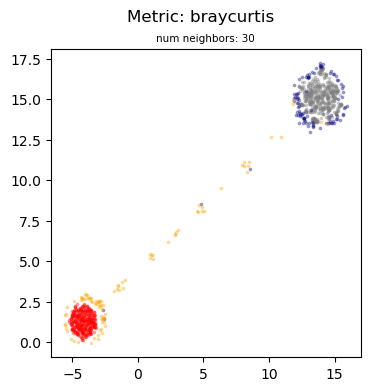

In [107]:
# plot
plt.close("all")

fig, ax = plt.subplots(figsize=(4, 4))

# axes = axes.flatten()

i = 0
ax.scatter(umap_train[i][~y_train, 0], umap_train[i][~y_train, 1], 
           c="gray", label="song-train", alpha=0.3, s=3)
ax.scatter(umap_test[i][~y_test, 0], umap_test[i][~y_test, 1], 
           c="navy", label="song-test", alpha=0.3, s=3)

ax.scatter(umap_train[i][y_train, 0], umap_train[i][y_train, 1], 
           c="red", label="ad-train", alpha=0.3, s=3)
ax.scatter(umap_test[i][y_test, 0], umap_test[i][y_test, 1], 
           c="orange", label="ad-test", alpha=0.3, s=3)

# ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)
ax.set_title(f'num neighbors: {params["n_neighbors"]}', fontsize=7.5)

# plt.legend(loc="upper right")

# fig.suptitle(f'Metric: {params_combined[i]["metric"]}')
fig.suptitle(f'Metric: {params["metric"]}')

# plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-supervised-umap-{params_combined[i]['metric']}.png", dpi=300)

plt.show()

In [115]:
combined = np.concatenate([umap_train[i], umap_test[i]], axis=0)

In [116]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(combined)

In [142]:
y_true = y_test.astype(np.int32)
y_pred = 1 - kmeans.labels_[X_train.shape[0]:]

In [144]:
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"F1 Score: {f1_score(y_true, y_pred)}")
print(f"Precision Score: {precision_score(y_true, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred)}")

Accuracy: 0.9175257731958762
F1 Score: 0.9101123595505618
Precision Score: 0.9642857142857143
ROC AUC Score: 0.9158510638297872


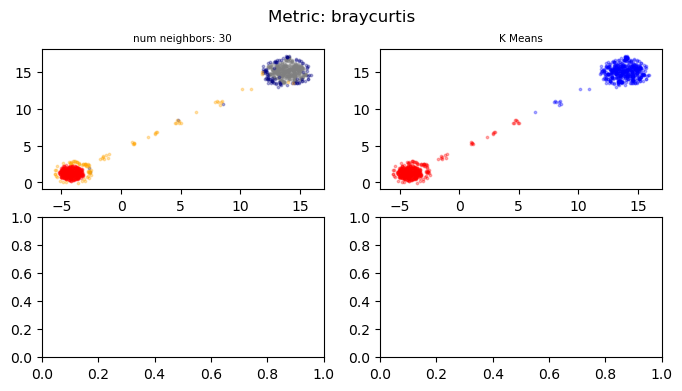

In [154]:
# plot
plt.close("all")

fig, ax = plt.subplots(2, 2, figsize=(8, 4))

i = 0

ax[i, 0].scatter(umap_train[i][~y_train, 0], umap_train[i][~y_train, 1], 
           c="gray", label="song-train", alpha=0.3, s=3)
ax[i, 0].scatter(umap_test[i][~y_test, 0], umap_test[i][~y_test, 1], 
           c="navy", label="song-test", alpha=0.3, s=3)

ax[i, 0].scatter(umap_train[i][y_train, 0], umap_train[i][y_train, 1], 
           c="red", label="ad-train", alpha=0.3, s=3)
ax[i, 0].scatter(umap_test[i][y_test, 0], umap_test[i][y_test, 1], 
           c="orange", label="ad-test", alpha=0.3, s=3)

# ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)
ax[i, 0].set_title(f'num neighbors: {params["n_neighbors"]}', fontsize=7.5)



# K Means labelling
combined_pred = kmeans.labels_.astype(bool)
ax[i, 1].scatter(combined_data[~combined_pred, 0], combined_data[~combined_pred, 1], 
           c="red", label="song", alpha=0.3, s=3)
ax[i, 1].scatter(combined_data[combined_pred, 0], combined_data[combined_pred, 1], 
           c="blue", label="ad", alpha=0.3, s=3)

# ax.set_title('K Means', fontsize=7.5)
ax[i, 1].set_title('K Means', fontsize=7.5)


# fig.suptitle(f'Metric: {params_combined[i]["metric"]}')
fig.suptitle(f'Metric: {params["metric"]}')

# plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-supervised-umap-{params_combined[i]['metric']}.png", dpi=300)

plt.show()

## Plots

In [60]:
embedding_dim = 3

In [66]:
pca = PCA(n_components=embedding_dim)
model_pca = pca.fit(X)
embed_pca = model_pca.transform(X)
fit_variances = model_pca.explained_variance_ratio_

spectral = SpectralEmbedding(**{'affinity': 'nearest_neighbors', 'n_components': embedding_dim, 'n_neighbors': 16})
embed_spectral = spectral.fit_transform(X)

model = TSNE(**{'n_components': embedding_dim, 'perplexity': 256}, n_iter=10000)
embed_tnse = model.fit_transform(X)

model = umap.UMAP(**{'metric': 'chebyshev', 'min_dist': 0.0, 'n_components': embedding_dim, 'n_neighbors': 50})
embed_umap = model.fit_transform(X)

In [68]:
%matplotlib widget

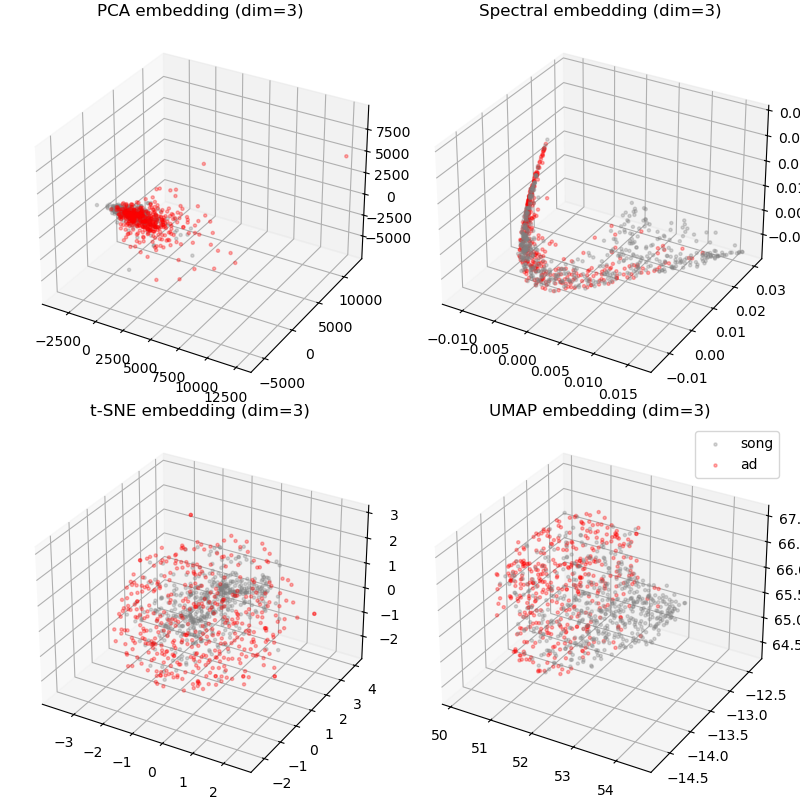

In [69]:
plt.close("all")

fig, ax = plt.subplots(2, 2, figsize=(8, 8), layout="constrained", subplot_kw=dict(projection="3d"))

ax = ax.flatten()

ax[0].scatter3D(embed_pca[~y, 0], embed_pca[~y, 1], embed_pca[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[0].scatter3D(embed_pca[y, 0], embed_pca[y, 1], embed_pca[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[0].set_title(f"PCA embedding (dim={embedding_dim})")


ax[1].scatter3D(embed_spectral[~y, 0], embed_spectral[~y, 1], embed_spectral[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[1].scatter3D(embed_spectral[y, 0], embed_spectral[y, 1], embed_spectral[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[1].set_title(f"Spectral embedding (dim={embedding_dim})")


ax[2].scatter3D(embed_tnse[~y, 0], embed_tnse[~y, 1], embed_tnse[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[2].scatter3D(embed_tnse[y, 0], embed_tnse[y, 1], embed_tnse[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[2].set_title(f"t-SNE embedding (dim={embedding_dim})")


ax[3].scatter3D(embed_umap[~y, 0], embed_umap[~y, 1], embed_umap[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[3].scatter3D(embed_umap[y, 0], embed_umap[y, 1], embed_umap[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[3].set_title(f"UMAP embedding (dim={embedding_dim})")

plt.legend(loc="best")

# plt.savefig(f"graphics/embedding-{embedding_dim}d.png", dpi=300)

plt.show()